# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle. 

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [14]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [15]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

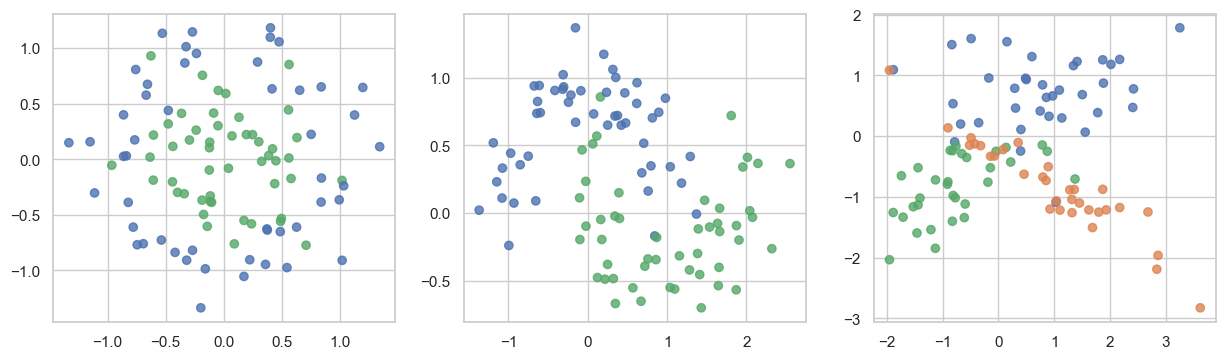

In [16]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [17]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

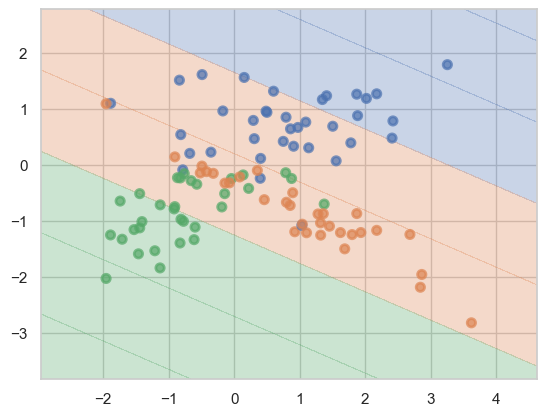

In [18]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

Датасет 1
Accuracy на обучающей выборке: 1.0000
Accuracy на тестовой выборке: 0.7333


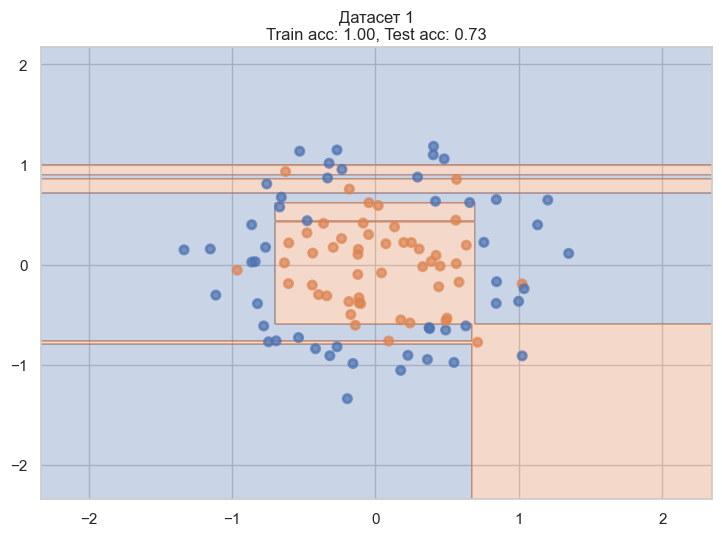

Датасет 2
Accuracy на обучающей выборке: 1.0000
Accuracy на тестовой выборке: 0.8667


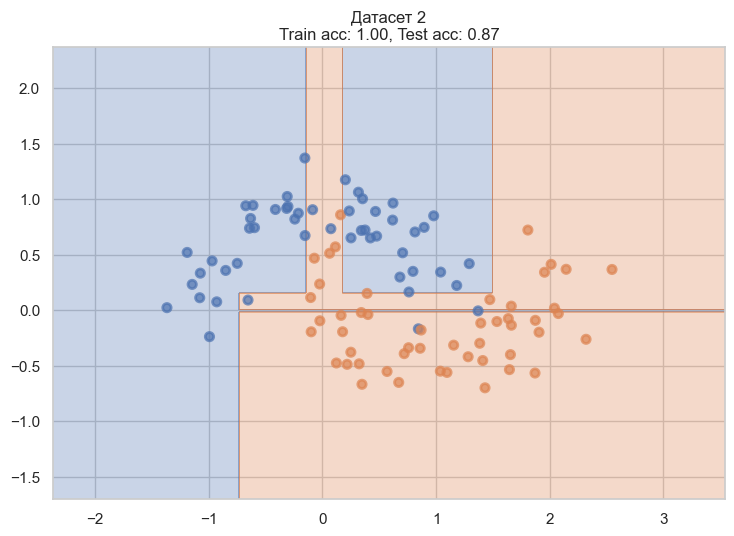

Датасет 3
Accuracy на обучающей выборке: 1.0000
Accuracy на тестовой выборке: 0.8333


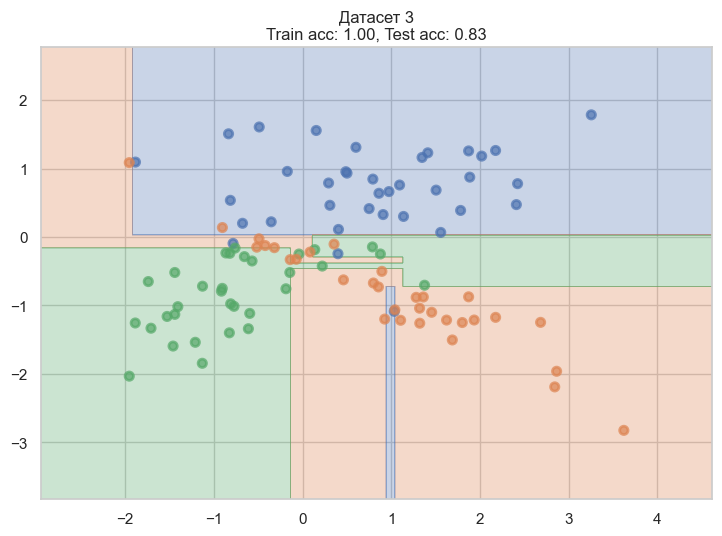

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    train_accuracy = accuracy_score(y_train, clf.predict(X_train))
    test_accuracy = accuracy_score(y_test, clf.predict(X_test))

    print(f"Датасет {i+1}")
    print(f"Accuracy на обучающей выборке: {train_accuracy:.4f}")
    print(f"Accuracy на тестовой выборке: {test_accuracy:.4f}")

    plt.figure(figsize=(8, 6))
    plt.title(f"Датасет {i+1}\nTrain acc: {train_accuracy:.2f}, Test acc: {test_accuracy:.2f}")

    plot_surface(clf, X, y)
    plt.show()

__Ответ:__
 Решающее дерево с параметрами по умолчанию (в частности, неограниченной глубиной max_depth=None) склонно к сильному переобучению. Оно строит избыточно сложную модель, которая не способна хорошо работать на новых, невиданных ранее данных.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

1. max_depth

Датасет 1


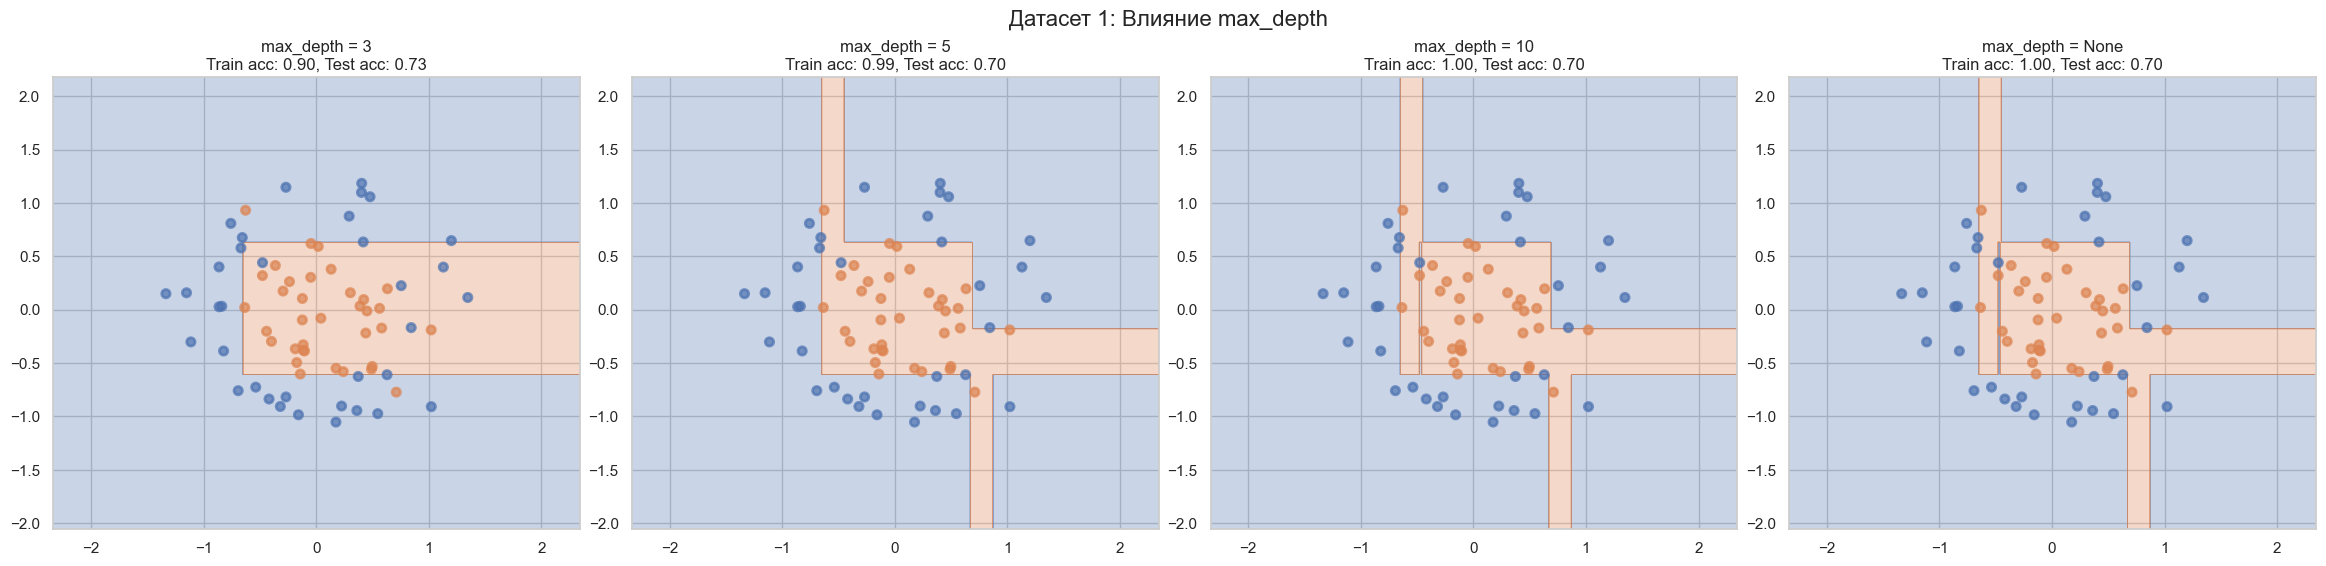


Датасет 2


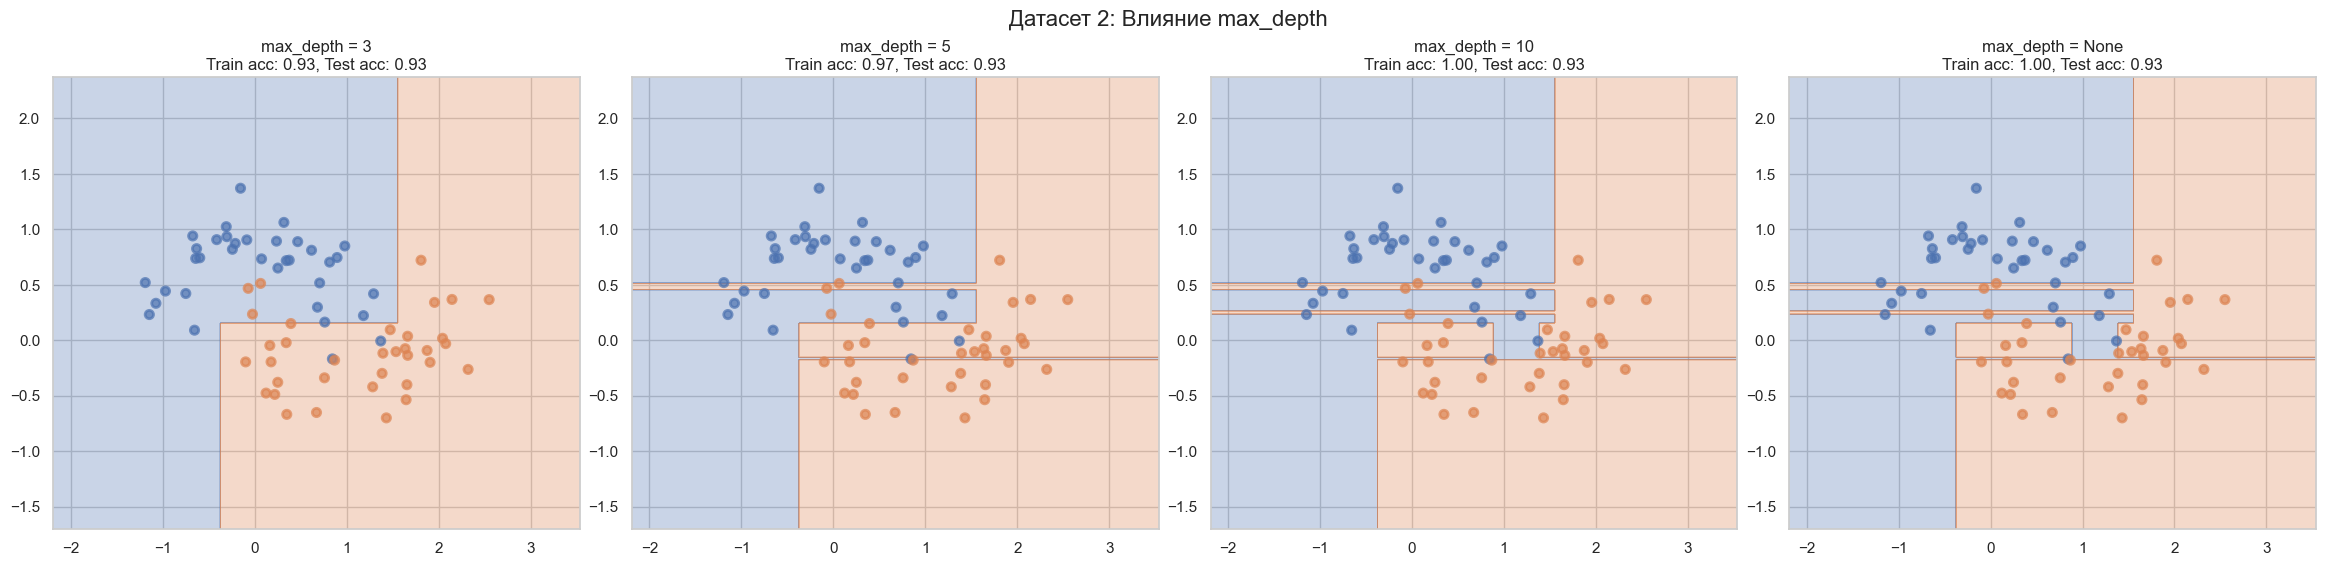


Датасет 3


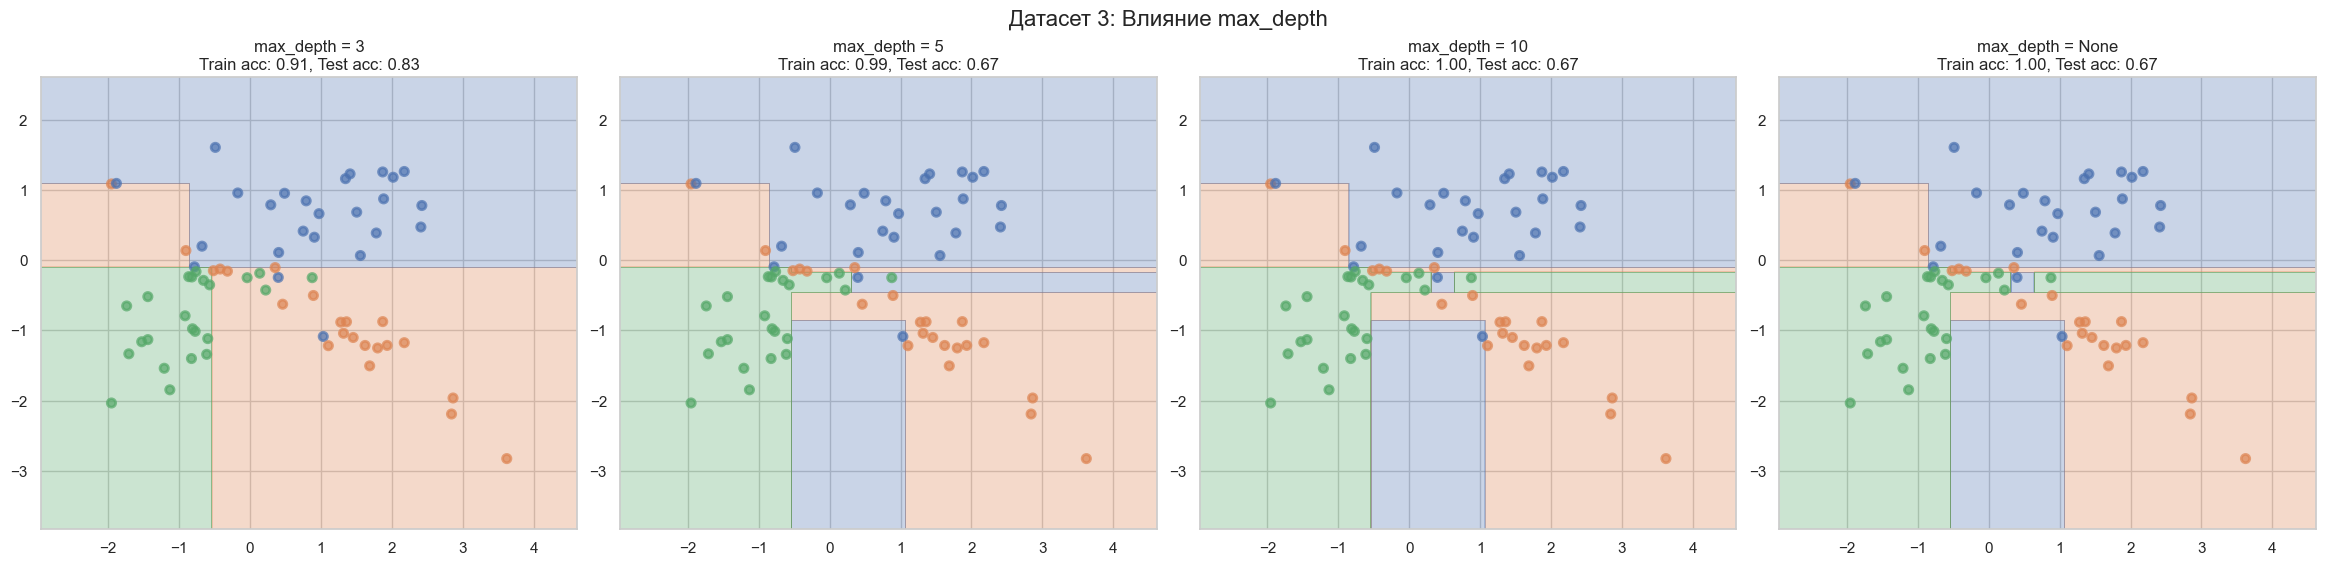



2. min_samples_leaf

Датасет 1


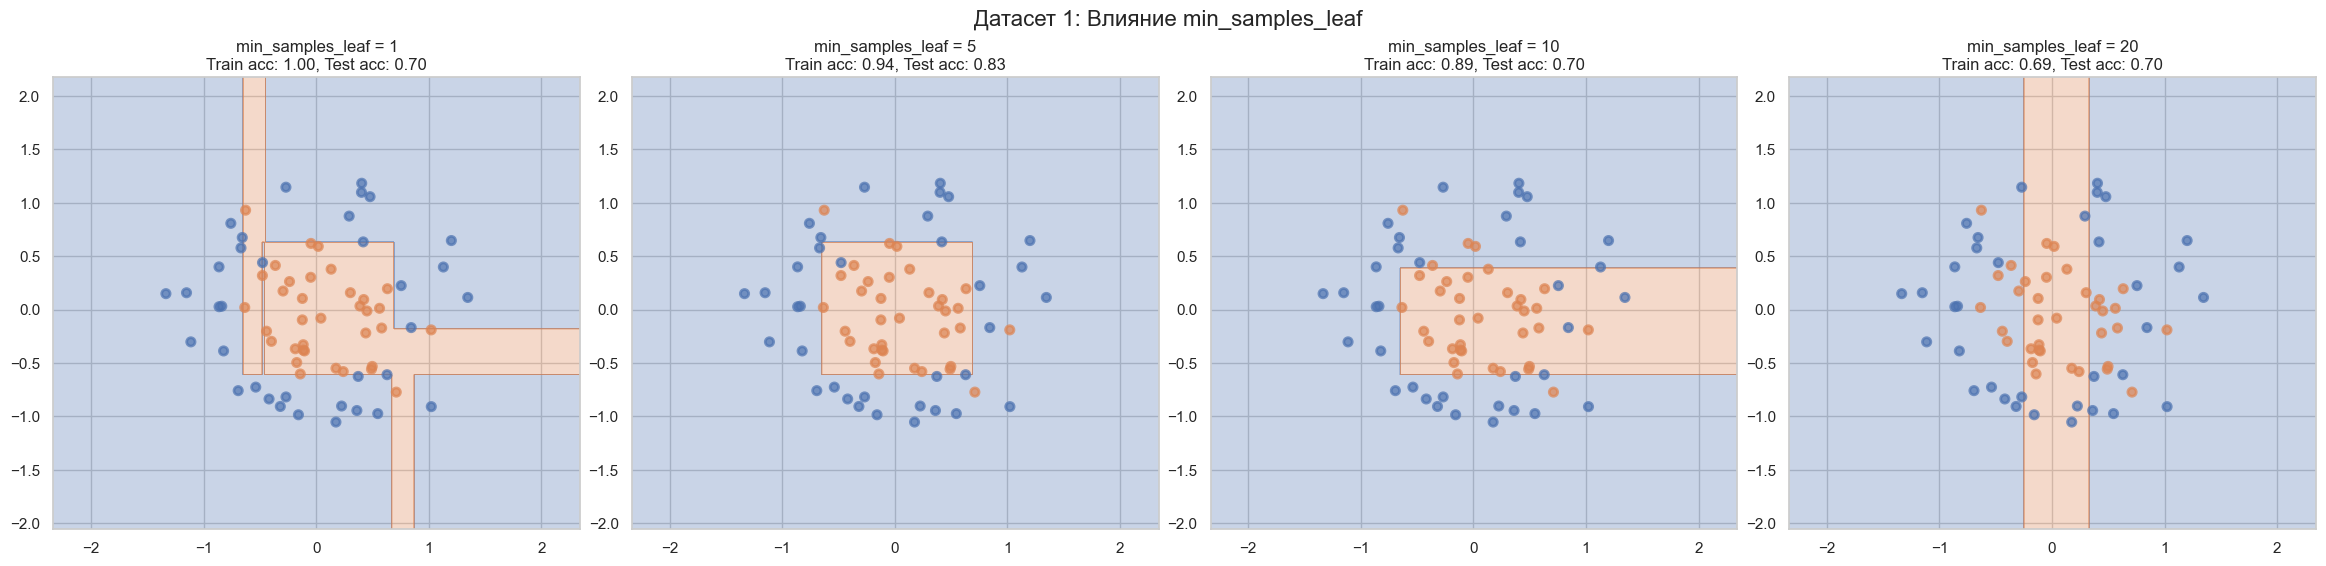


Датасет 2


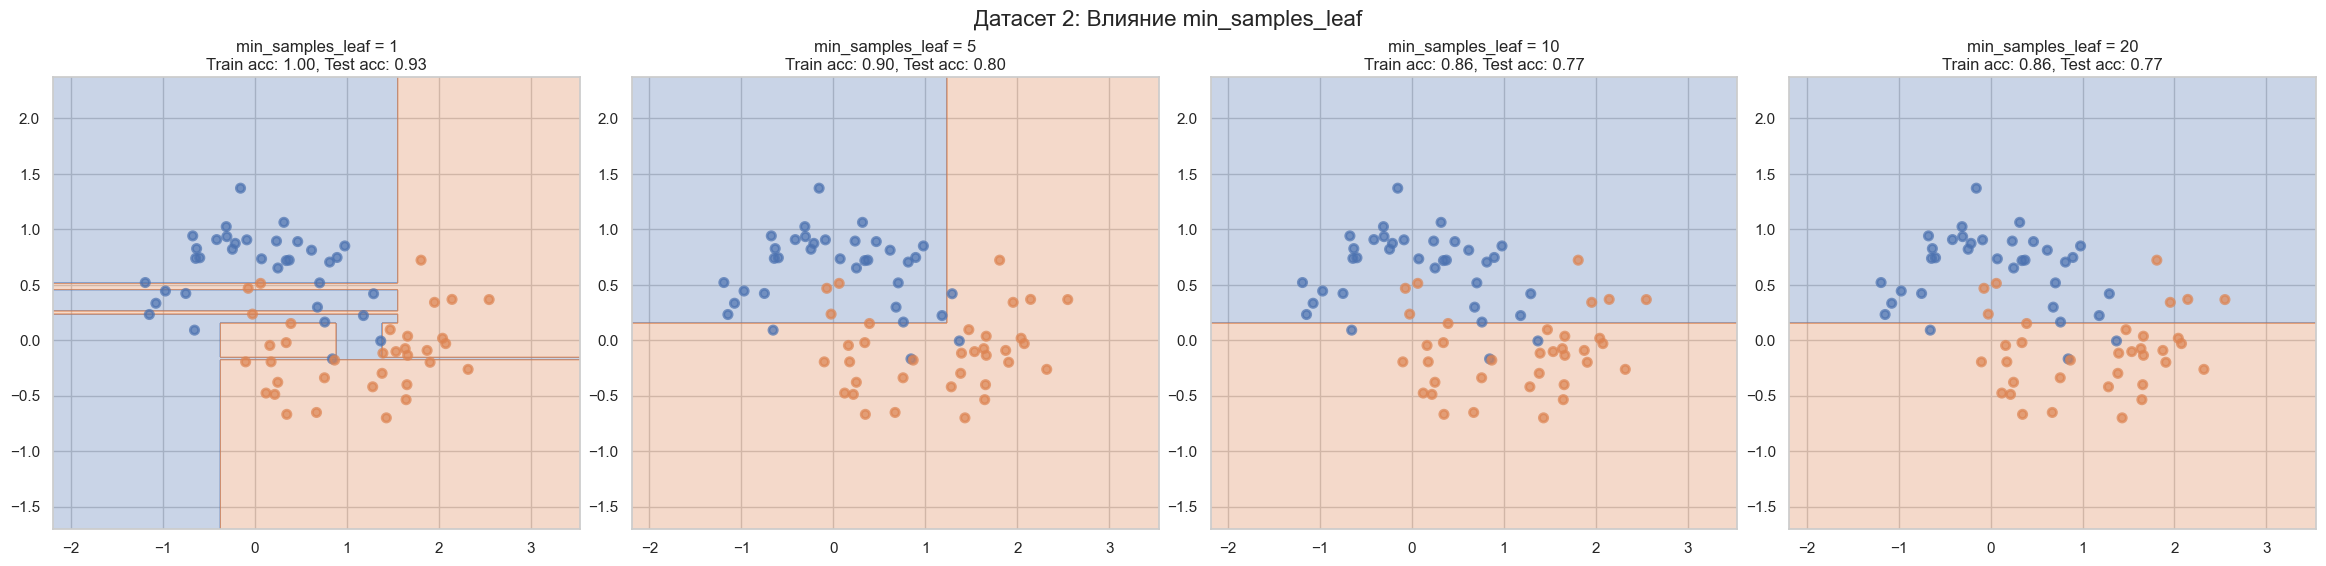


Датасет 3


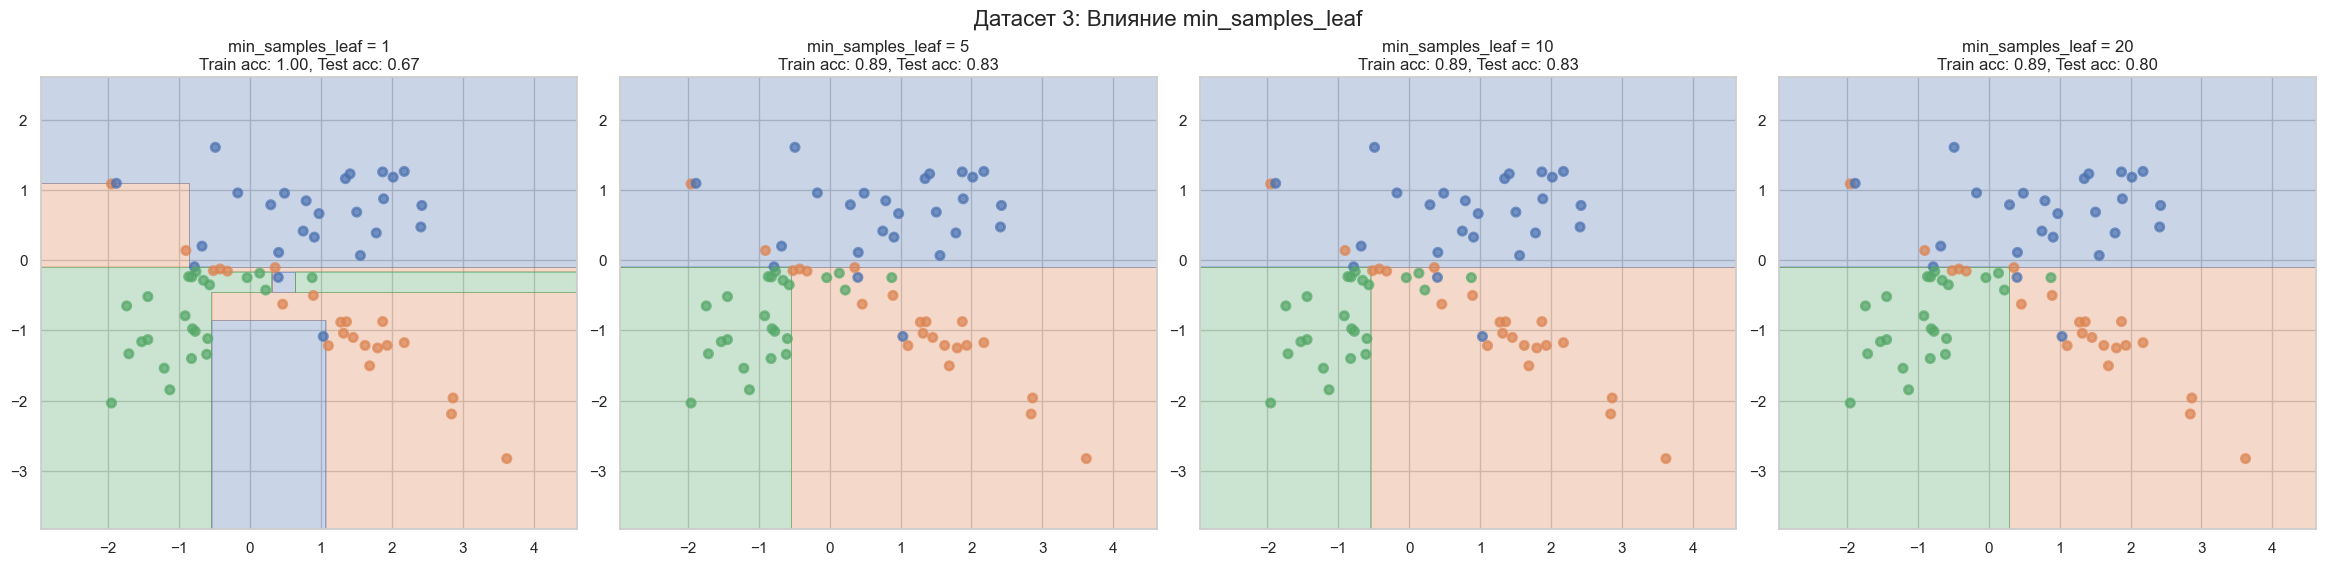

In [20]:
max_depth_values = [3, 5, 10, None]

print("1. max_depth")

for i, (X, y) in enumerate(datasets):
    print(f"\nДатасет {i+1}")

    plt.figure(figsize=(24, 6))

    for j, depth in enumerate(max_depth_values):
        plt.subplot(1, len(max_depth_values), j + 1)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

        clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
        clf.fit(X_train, y_train)

        train_accuracy = accuracy_score(y_train, clf.predict(X_train))
        test_accuracy = accuracy_score(y_test, clf.predict(X_test))

        plot_surface(clf, X_train, y_train) # Используем только train для отрисовки точек

        depth_title = f"max_depth = {depth}" if depth is not None else "max_depth = None"
        plt.title(f"{depth_title}\nTrain acc: {train_accuracy:.2f}, Test acc: {test_accuracy:.2f}")

    plt.suptitle(f"Датасет {i+1}: Влияние max_depth", fontsize=16)
    plt.show()



min_samples_leaf_values = [1, 5, 10, 20]

print("\n\n2. min_samples_leaf")

for i, (X, y) in enumerate(datasets):
    print(f"\nДатасет {i+1}")

    plt.figure(figsize=(24, 6))

    for j, leaf_size in enumerate(min_samples_leaf_values):
        plt.subplot(1, len(min_samples_leaf_values), j + 1)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
        clf = DecisionTreeClassifier(min_samples_leaf=leaf_size, random_state=42)
        clf.fit(X_train, y_train)

        train_accuracy = accuracy_score(y_train, clf.predict(X_train))
        test_accuracy = accuracy_score(y_test, clf.predict(X_test))

        plot_surface(clf, X_train, y_train)
        plt.title(f"min_samples_leaf = {leaf_size}\nTrain acc: {train_accuracy:.2f}, Test acc: {test_accuracy:.2f}")

    plt.suptitle(f"Датасет {i+1}: Влияние min_samples_leaf", fontsize=16)
    plt.show()

__Ответ:__
При изменении гиперпараметров регуляризации, таких как max_depth и min_samples_leaf, наблюдается прямое влияние как на вид разделяющей поверхности, так и на обобщающую способность модели. С увеличением max_depth или уменьшением min_samples_leaf разделяющая поверхность становится сложнее и детальнее, создавая множество мелких прямоугольных областей. Наоборот, ограничение глубины или увеличение минимального числа объектов в листе приводит к более простым и гладким границам.

Это напрямую влияет на обобщающую способность: избыточно сложные модели (например, с неограниченной глубиной) идеально подгоняются под обучающие данные, достигая максимальной точности на них, но при этом запоминают шум. В результате их точность на тестовой выборке падает, что является признаком переобучения. Параметры регуляризации заставляют дерево строить более общие правила, что снижает переобучение и, до определённого предела, улучшает качество на тестовых данных. Однако слишком сильные ограничения (очень маленькая глубина или большое число объектов в листе) могут привести к недообучению, когда модель не способна уловить даже основные закономерности в данных.

Эффект от регуляризации проявляется по-разному на разных датасетах. Например, для данных с простой структурой (Датасет 3) даже дерево с малой глубиной показывает хороший результат, и дальнейшее усложнение только вредит. В то же время, для данных с более сложной нелинейной зависимостью (Датасет 2) требуется более глубокое дерево, чтобы достичь максимальной точности на тестовой выборке, и оптимальное значение гиперпараметра оказывается другим.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

Первые 5 строк данных:
    STG   SCG   STR   LPR   PEG  UNS
0  0.00  0.00  0.00  0.00  0.00    0
1  0.08  0.08  0.10  0.24  0.90    1
2  0.06  0.06  0.05  0.25  0.33    0
3  0.10  0.10  0.15  0.65  0.30    1
4  0.08  0.08  0.08  0.98  0.24    0
------------------------------


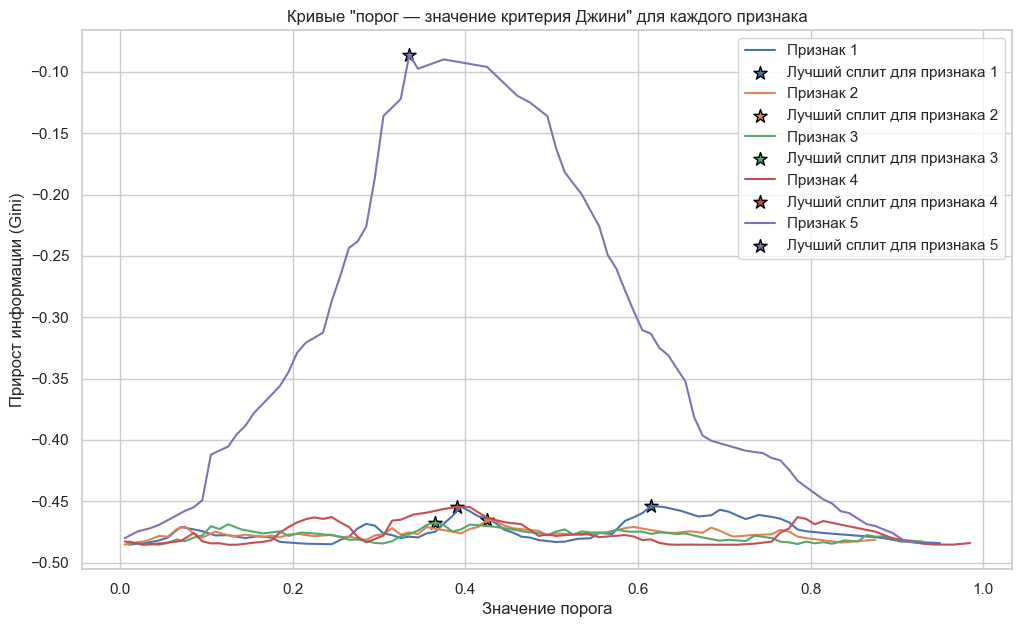

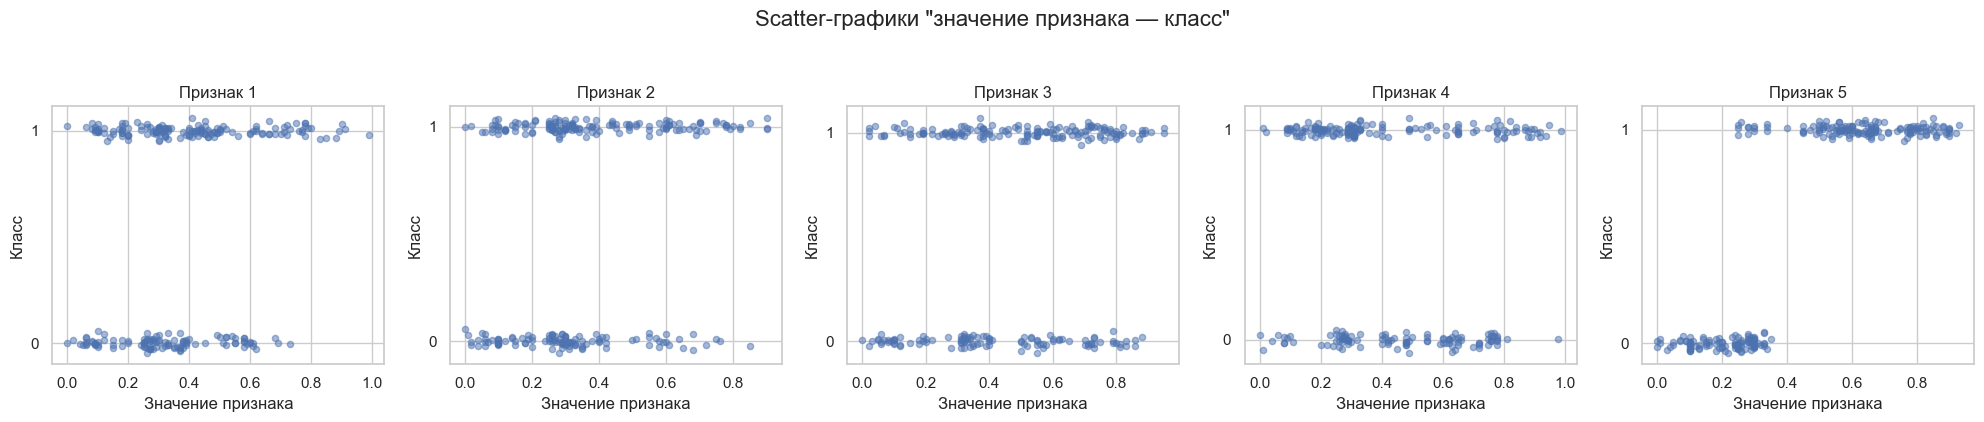

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hw2code import find_best_split


data = pd.read_csv('students.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

print("Первые 5 строк данных:")
print(data.head())
print("-" * 30)

plt.figure(figsize=(12, 7))

for i in range(X.shape[1]):
    thresholds, ginis, threshold_best, gini_best = find_best_split(X[:, i], y)
    plt.plot(thresholds, ginis, label=f'Признак {i+1}')
    if threshold_best is not None:
        plt.scatter([threshold_best], [gini_best], s=100, edgecolors='black', marker='*',
                    label=f'Лучший сплит для признака {i+1}')

plt.title('Кривые "порог — значение критерия Джини" для каждого признака')
plt.xlabel('Значение порога')
plt.ylabel('Прирост информации (Gini)')
plt.legend()
plt.grid(True)
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i in range(X.shape[1]):
    ax = axes[i]
    jitter = np.random.normal(0, 0.02, size=y.shape)

    ax.scatter(X[:, i], y + jitter, alpha=0.5, s=20)

    ax.set_title(f'Признак {i+1}')
    ax.set_xlabel('Значение признака')
    ax.set_ylabel('Класс')
    ax.set_yticks([0, 1])

plt.suptitle('Scatter-графики "значение признака — класс"', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()


__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**

Исходя из графика кривых Джини, деление выборки следует производить по Признаку 4. Его кривая имеет самый высокий пик (ближе всего к нулю), что соответствует максимальному приросту информации. Оптимальный порог для разделения находится примерно в районе значения 0.2.

Да, этот результат полностью согласуется с визуальной оценкой scatter-графиков. Только на графике для Признака 4 наблюдается явное разделение классов: объекты класса 0 в основном сконцентрированы при низких значениях признака, а объекты класса 1 — при высоких. На графиках для остальных признаков точки обоих классов полностью перемешаны, что указывает на их низкую предсказательную способность.

Кривая для "хорошего" признака (в данном случае, Признака 4) имеет ярко выраженную параболическую или колоколообразную форму с высоким и узким пиком. Высота пика говорит о высокой "чистоте" получаемых подвыборок, а его узость — о том, что оптимальный порог разделения находится в небольшом диапазоне значений.

Кривые для признаков, по которым деление практически невозможно (Признаки 1, 2, 3, 5), выглядят почти как горизонтальные линии, расположенные на низком уровне. У них нет выраженного пика, а значения критерия Джини слабо меняются в зависимости от порога. Это означает, что любое разделение по такому признаку дает подвыборки, которые почти так же "грязные" (смешанные), как и исходная.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from hw2code import DecisionTree

mushrooms_data = pd.read_csv('agaricus-lepiota.data', header=None)

mushrooms_encoded = pd.DataFrame()

for column in mushrooms_data.columns:
    le = LabelEncoder()
    mushrooms_encoded[column] = le.fit_transform(mushrooms_data[column])

y = mushrooms_encoded[0].values
X = mushrooms_encoded.iloc[:, 1:].values

print("Размерность матрицы признаков X:", X.shape)
print("Размерность вектора классов y:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
feature_types = ["categorical"] * X.shape[1]

my_tree = DecisionTree(feature_types=feature_types)
my_tree.fit(X_train, y_train)
y_pred = my_tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"\nAccuracy нашего решающего дерева на датасете mushrooms: {accuracy:.4f}")
def get_tree_depth(node):
    if not node or node.get("type") == "terminal":
        return 1

    left_depth = get_tree_depth(node.get("left_child", {}))
    right_depth = get_tree_depth(node.get("right_child", {}))

    return 1 + max(left_depth, right_depth)

depth = get_tree_depth(my_tree._tree)
print(f"Глубина построенного дерева: {depth}")


Размерность матрицы признаков X: (8124, 22)
Размерность вектора классов y: (8124,)

Accuracy нашего решающего дерева на датасете mushrooms: 1.0000
Глубина построенного дерева: 9


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

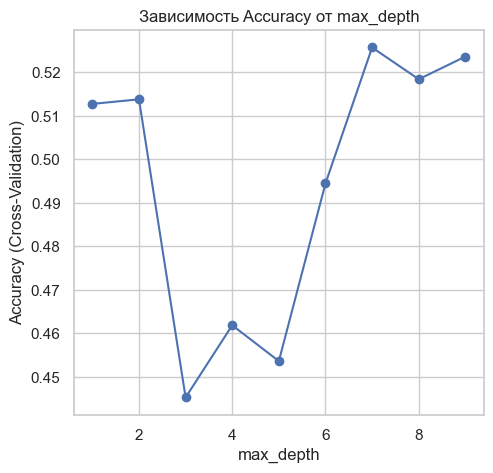

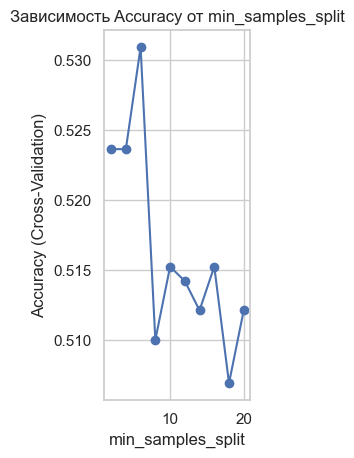

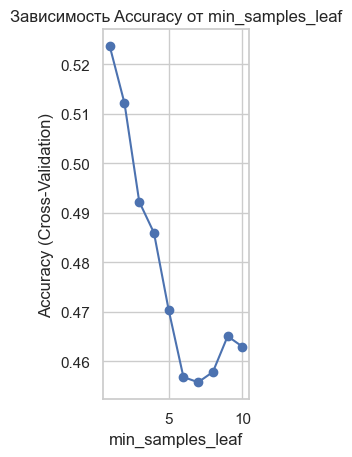

<Figure size 640x480 with 0 Axes>

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ttt_data = pd.read_csv('tic-tac-toe-endgame.csv')
ttt_encoded = pd.DataFrame()

for col in ttt_data.columns:
    le = LabelEncoder()
    ttt_encoded[col] = le.fit_transform(ttt_data[col])

X_ttt = ttt_encoded.iloc[:, :-1].values
y_ttt = ttt_encoded.iloc[:, -1].values

feature_types_ttt = ['categorical'] * X_ttt.shape[1]

def plot_dependency(param_name, param_values, X, y, feature_types):
    scores = []
    for value in param_values:
        if param_name == 'max_depth':
            clf = DecisionTree(feature_types=feature_types, max_depth=value)
        elif param_name == 'min_samples_split':
            clf = DecisionTree(feature_types=feature_types, min_samples_split=value)
        elif param_name == 'min_samples_leaf':
            clf = DecisionTree(feature_types=feature_types, min_samples_leaf=value)

        scorer = make_scorer(accuracy_score)
        score = np.mean(cross_val_score(clf, X, y, cv=5, scoring=scorer))
        scores.append(score)

    plt.plot(param_values, scores, marker='o')
    plt.title(f'Зависимость Accuracy от {param_name}')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy (Cross-Validation)')
    plt.grid(True)
    plt.show()

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
depths = range(1, 10)
plot_dependency('max_depth', depths, X_ttt, y_ttt, feature_types_ttt)

plt.subplot(1, 3, 2)
splits = range(2, 21, 2)
plot_dependency('min_samples_split', splits, X_ttt, y_ttt, feature_types_ttt)

plt.subplot(1, 3, 3)
leaves = range(1, 11)
plot_dependency('min_samples_leaf', leaves, X_ttt, y_ttt, feature_types_ttt)

plt.tight_layout()

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

datasets_info = {
    'mushrooms': {
        'df': mushrooms_encoded,
        'target_col': 0
    },
    'tic-tac-toe': {
        'url': 'tic-tac-toe-endgame.csv',
        'target_col': -1,
        'target_map': None
    },
    'cars': {
        'url': 'car.data',
        'target_col': -1,
        'target_map': {'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1}
    },
    'nursery': {
        'url': 'nursery.data',
        'target_col': -1,
        'target_map': {'not_recom': 0, 'recommend': 0, 'very_recom': 1, 'priority': 1, 'spec_prior': 1}
    }
}

for name, info in datasets_info.items():
    if 'url' in info:
        if name == 'tic-tac-toe':
            df = pd.read_csv(info['url'])
            df_encoded = pd.DataFrame()
            for col in df.columns:
                le = LabelEncoder()
                df_encoded[col] = le.fit_transform(df[col])
            info['df'] = df_encoded
        else:
            df = pd.read_csv(info['url'], header=None)
            df_encoded = pd.DataFrame()
            for col in df.columns:
                le = LabelEncoder()
                df_encoded[col] = le.fit_transform(df[col])

            target_col_index = df.columns[info['target_col']]
            if info['target_map']:
                df_encoded[target_col_index] = df[target_col_index].map(info['target_map'])

            info['df'] = df_encoded

results = {}
scorer = make_scorer(accuracy_score)

for name, info in datasets_info.items():
    print(f"Обработка датасета: {name}...")

    df = info['df']
    target_col_index = df.columns[info['target_col']]

    y = df[target_col_index].values
    X = df.drop(columns=[target_col_index]).values

    ft_real = ['real'] * X.shape[1]
    tree_real = DecisionTree(feature_types=ft_real)
    score_real = np.mean(cross_val_score(tree_real, X, y, cv=10, scoring=scorer))

    ft_cat = ['categorical'] * X.shape[1]
    tree_cat = DecisionTree(feature_types=ft_cat)
    score_cat = np.mean(cross_val_score(tree_cat, X, y, cv=10, scoring=scorer))

    preprocessor = ColumnTransformer([('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), list(range(X.shape[1])))])
    tree_ohe = Pipeline([('preprocessor', preprocessor), ('classifier', DecisionTree(feature_types=['real'] * (preprocessor.fit(X).transform(X).shape[1])))])
    score_ohe = np.mean(cross_val_score(tree_ohe, X, y, cv=10, scoring=scorer))

    clf_sklearn = DecisionTreeClassifier()
    score_sklearn = np.mean(cross_val_score(clf_sklearn, X, y, cv=10, scoring=scorer))

    results[name] = {
        'MyTree (real)': score_real,
        'MyTree (categorical)': score_cat,
        'MyTree (OHE)': score_ohe,
        'Sklearn Tree': score_sklearn
    }

results_df = pd.DataFrame(results).T
print("\nРезультаты эксперимента (accuracy, cv=10):")
display(results_df)


Обработка датасета: mushrooms...
Обработка датасета: tic-tac-toe...
Обработка датасета: cars...
Обработка датасета: nursery...

Результаты эксперимента (accuracy, cv=10):


,MyTree (real),MyTree (categorical),MyTree (OHE),Sklearn Tree
mushrooms,0.999261,1.000000,0.999631,0.961123
tic-tac-toe,0.467533,0.541458,0.543575,0.786272
cars,0.942647,0.967546,0.919495,0.943285
nursery,0.999691,0.999846,0.999537,0.999691


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента.
Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.

Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**
Результаты показывают, что лучший алгоритм зависит от данных. На чисто категориальных датасетах (mushrooms, tic-tac-toe) наша специальная обработка категорий (MyTree (categorical)) побеждает, так как стандартный подход (MyTree (real)) не может найти осмысленные пороги в числовых метках. Sklearn занимает промежуточную позицию. На данных с более простой структурой (cars, nursery) все методы работают одинаково хорошо.

Случайность в результатах присутствует из-за кросс-валидации. Её можно устранить, зафиксировав random_state. Улучшить работу алгоритмов можно путем подбора гиперпараметров, таких как max_depth, для контроля переобучения.

Вставьте что угодно, описывающее ваши впечатления от этого задания:

=)
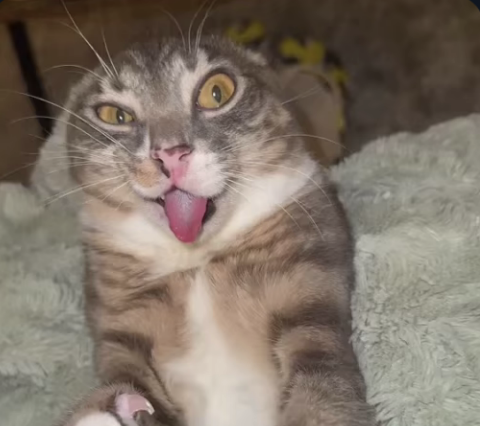
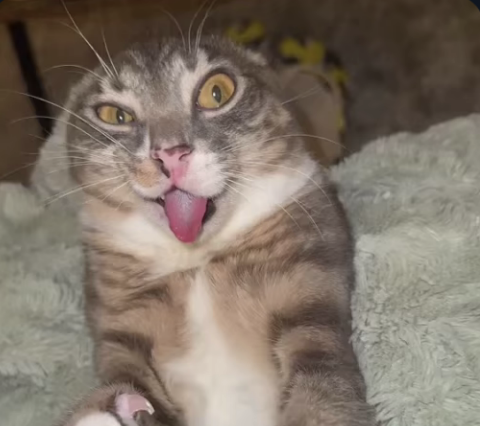